In [1]:
## custom
import utils, vis
import criteria as C


## third party
import networkx as nx
import poly_point_isect as bo   ##bentley-ottmann sweep line

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Optimize via Stochastic Gradient Descent (SGD)

In [9]:
# import importlib
# C = importlib.reload(C)

## test runtime

In [3]:
# delete old
# !rm -r fig
!mkdir fig

mkdir: fig: File exists


In [198]:
def crossings(pos, G, k2i, sampleSize, sampleOn='edges', reg_coef=1, niter=30):
    crossing_segs_sample = utils.sample_crossings(pos, G, k2i, sampleSize, sampleOn)
    if len(crossing_segs_sample) > 0:
        pos_segs = pos[crossing_segs_sample.flatten()].view(-1,4,2)
        w = (torch.rand(pos_segs.shape[0], 2, 1)-0.5).requires_grad_(True)
        b = (torch.rand(pos_segs.shape[0], 1, 1)-0.5).requires_grad_(True)
        relu = nn.ReLU()
        o = optim.SGD([w,b], lr=0.01, momentum=0.5, nesterov=True)
        for _ in range(niter):
            pred = pos_segs.detach() @ w + b
            ## assume labels of nodes in the first edges are -1
            ## now flip the pred of those nodes so that now we want every pred to be +1
            pred[:,:2,:] = -pred[:,:2,:]
            
            loss_svm = relu(1-pred).sum() + reg_coef * w.pow(2).sum()
            o.zero_grad()
            loss_svm.backward()
            o.step()
#         return w, b
        pred = pos_segs @ w.detach() + b.detach()
        pred[:,:2,:] = -pred[:,:2,:] 
        loss_crossing = relu(1-pred).sum()
        return loss_crossing
    else:
        ##return dummy loss
        return (pos[0,0]*0).sum()

In [199]:
G = nx.Graph()
G.add_nodes_from([0,1,2,3])
G.add_edges_from([(0,1),(2,3)])

print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
i2k = {i:k for k,i in k2i.items()}
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+np.eye(len(G)))
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
pos = torch.tensor([[-1.0,-1],[1,1],[2,0],[0,1]])
# pos = torch.randn(len(G.nodes), 2, device=device)

pos.requires_grad_(True)

w,b = crossings(pos, G, k2i, reg_coef=2, niter=200, sampleSize=10, )
w,b
x,y = torch.meshgrid(torch.linspace(-5,5,20),torch.linspace(-5,5,20))
xy = torch.stack([x.reshape(-1), y.reshape(-1)], -1)
pred = (xy @ w.detach() + b.detach()).view(20,20)

plt.contourf(x,y,pred, levels=np.linspace(-5,5,21), cmap='coolwarm')
plt.contour(x,y,pred, levels=[-1,0,1])

pos_numpy = pos.detach().cpu().numpy()
pos_i = {k: pos_numpy[k2i[k], :2] for k in G.nodes}
nx.draw_networkx(G, pos_i)

of 4 nodes
Calculating all pairs shortest path...done


TypeError: iteration over a 0-d tensor

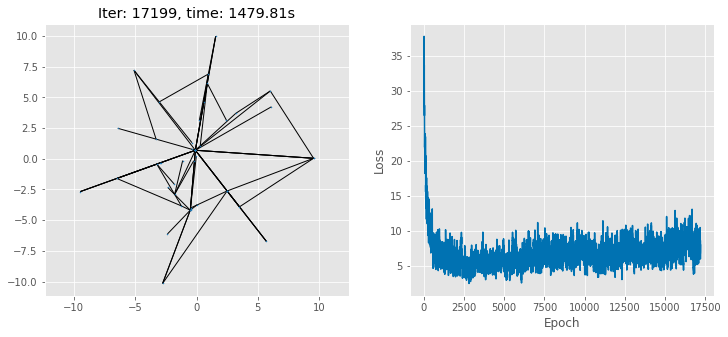

Epoch 17238: reducing learning rate of group 0 to 1.0000e-05.
Done


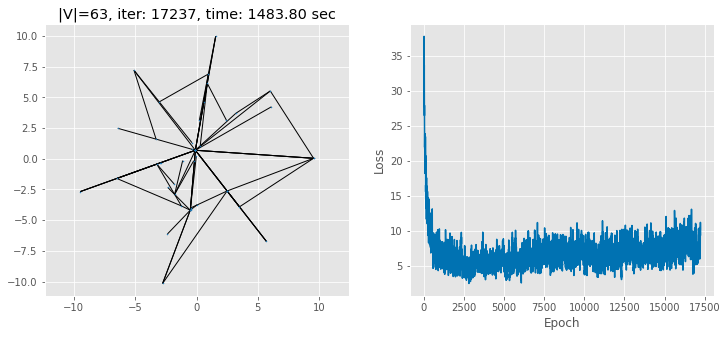

CPU times: user 25min 25s, sys: 51.7 s, total: 26min 17s
Wall time: 26min 1s


1483.797777414322

In [204]:
%%time

runtime = []

niter = int(1e5)

shouldVis = True
visIter = 100

shouldSnap = True
snapIter = 5

gClamp = 100
minLR = 1e-5
maxSampleSize = 128



totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(5,5)
# G = nx.hypercube_graph(3)
G = nx.balanced_tree(2,5)

# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])


print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
i2k = {i:k for k,i in k2i.items()}
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+np.eye(len(G)))
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)

optimizer = optim.SGD([pos], lr=0.05, momentum=0.5, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.1)
patience = np.ceil(np.log2(len(G)))*100
# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=patience, 
                                                 min_lr=minLR, verbose=True)

iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

for i in iterBar:
    t0 = time.time()
    optimizer.zero_grad()
#     loss = C.stress(pos, D, W, sampleSize)
#     loss = C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    loss = (
#         0.1*C.stress(pos, D, W, sampleSize)
#         1*C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         5 * C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
        # + C.aspect_ratio(pos, sampleSize)
#     + C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10) ## slow for large sample size
#     + 100*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
        crossings(pos, G, k2i, reg_coef=2, niter=200, sampleSize=10, )
    )

    
    
#     print(loss.item())
    if loss.isnan():
        print('loss is nan')
        break
        
        
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
#     print(pos)
    if pos.isnan().any():
        print('pos is nan')
        break

    ##debug info
    dt = time.time() - t0
    totalTime += dt
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({
            'loss': loss.item(), 
        })
#     print(utils.find_crossings(pos, G.edges, k2i).shape[0])

    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())

    if scheduler is not None:
#         scheduler.step()
        scheduler.step(lossCurve[-1])

    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, edge=True, show=True, save=False)
        prevTime = totalTime
        
    if optimizer.param_groups[0]['lr'] <= minLR:
        print('Done')
        break

## show final result
x = pos.detach().cpu().numpy()   
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=True, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime


In [14]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## save fig

## Animation

In [39]:
len(xPath)

188

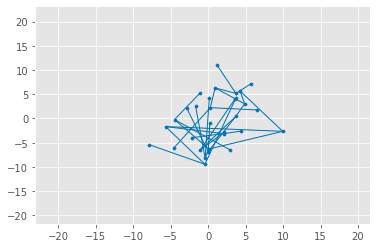

In [40]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

if type(xPath) == list:
    xPath = np.stack(xPath)
    
padding = 0.1

fig, ax = plt.subplots()
scatter = plt.scatter([0], [0], s=10)
lc = mc.LineCollection([], linewidths=1)
ax.add_collection(lc)

xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
    
def init():
    return scatter,lc

def update(frame):
    xy = xPath[frame]
    scatter.set_offsets(xy)
    segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
    lc.set_segments(segs)
    return scatter,lc

anim = FuncAnimation(
    fig, 
    update, 
    frames=range(0,len(xPath),1),
    init_func=init, 
    interval=1000.0/20,
    blit=True)

HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)